# CS-5600/6600 Lecture 6 - Decision Trees

**Instructor: Dylan Zwick**

*Weber State University*

Reference: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) by Aurélien Géron - [Decision Trees](https://github.com/ageron/handson-ml3/blob/main/06_decision_trees.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris

from graphviz import Source

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

<center>
  <img src="https://imgs.xkcd.com/comics/solar_panels.png" alt="Task from xkcd">
</center>

In this lecture we're going to learn about our first machine learning algorithm - a decision tree. A decision tree is a versatile machine learning algorithm that is easy to understand and can make both categorical and numerical predictions. The only problem with decision trees is - usually the models aren't very good, and they have a strong tendency to overfit.

However, it's a relatively easy model to understand, and they form the basis of the random forest model - an impressively performant model, particularly when there's not a ton of data and you don't have a lot of time.

## The Iris Dataset

The [iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) is a datset consisting of the measurements of the [sepal](https://en.wikipedia.org/wiki/Sepal) and petal lengths and widths from three different types of irises - setosa, versicolour, and virginica. The machine learning problem is to classify each iris in the dataset into its type.

The dataset is one of the smaller ones that's included with sklearn, and can be loaded with a "load" function (unlike the MNIST data, which was stored externally online and accessed with a "fetch"  function). Let's grab it.

In [2]:
iris = load_iris(as_frame=True)

We can check out the description of this dataset from its DESCR method.

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

For the purposes of this lecture, we'll just focus on the petal measurements.

In [4]:
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

We can visually examine how the different iris types distribute over petal length and width measurements.

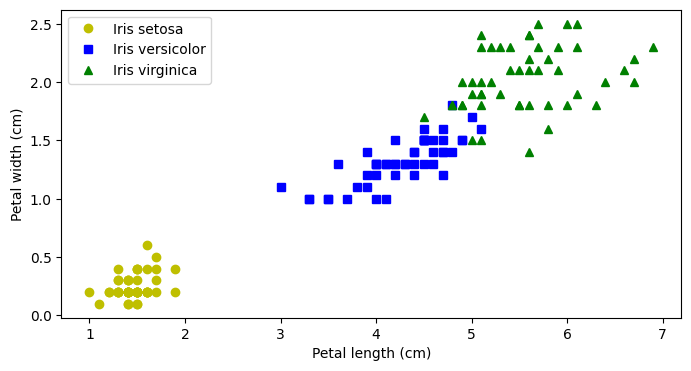

In [5]:
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx], style, label=f"Iris {name}")
plt.legend();

It appears the iris types should be fairly easy to distinguish based upon their petal measurements, particularly setosa.

## The Decision Tree Model

We'll now train a decision tree classifier on our Iris dataset.

In [18]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [16]:
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf.fit(X_iris, y_iris);

We can visualize the process used by this trained deceison tree with the [Graphviz](https://graphviz.org/) graph visualization library. First, we can use the export_graphviz() function to output a graph definition file called *iris_tree.dot*, and then load and display that file.

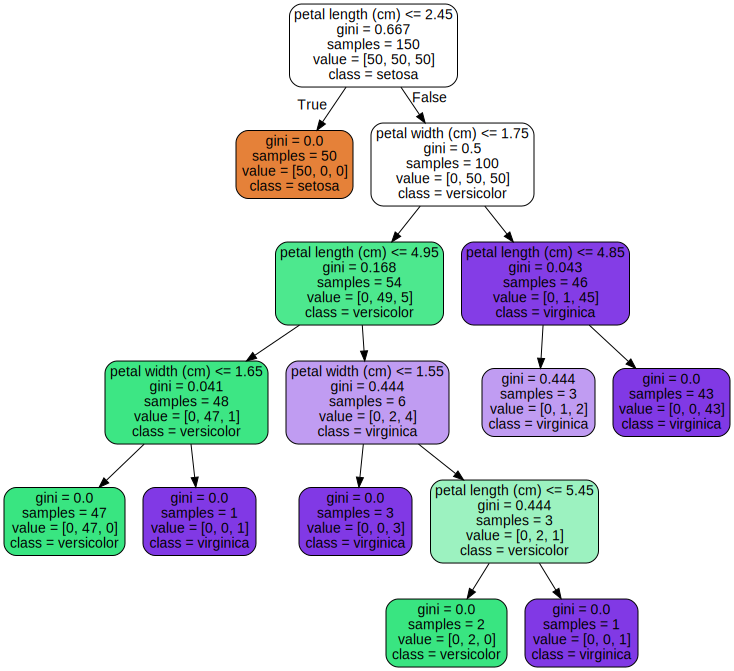

In [17]:
export_graphviz(
        tree_clf,
        out_file=str("iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )
Source.from_file("iris_tree.dot")

So what is this graph is telling us is that if the petal length is less than or equal to 2.45 cm, the model classifies the iris as *setosa*, and there are 50 samples that meet this criterion (all 50 setosa). If not, then if the petal width is less than or equal to 1.75 cm, the model classifies the iris as *versicolor*, and there are 54 samples that meet this criterion (49 versicolo, and 5 virginica). If not, then the model classifies the iris as *virginica*, and there are 46 samples that meet this criterion (1 versicolor, and 45 virginica). We'll talk about what "gini" means in a moment.

Pretty straightforward. How does this model do? Well, we can plot the decision boundaries on our data chart:

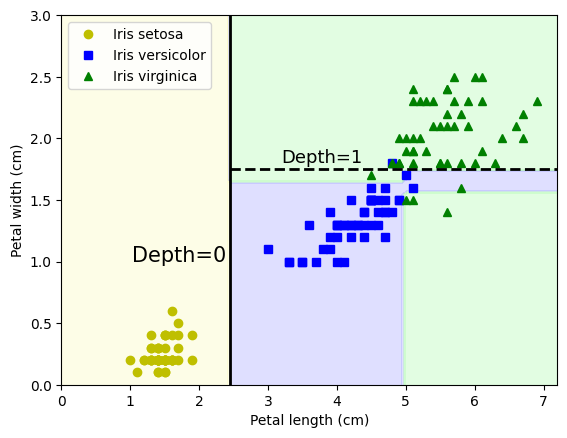

In [13]:
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf.tree_.threshold[[0, 2]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.legend()

plt.show()

Not bad! It gets a few wrong, but not many.

### How Subset Purity Is Measured



So, how does the decision tree determine how to make the split? Well, it tries to split things so that the subsets are as "pure" as possible, which means the subsets are as unmixed as possible. How is "purity" defined? Well, if $C$ is the set of possible classes, and $p_{c}$ represents the proportion (percentage) of samples in class $c$, then there are a number of ways to do so, including:
<br><br>

* *Classification Error Rate*:
<center>
    $\displaystyle E = 1-max_{c}(p_{c})$,
</center>
* *Gini Impurity*:
<center>
    $\displaystyle G = \sum_{c = 1}^{C}p_{c}(1-p_{c})$,
</center>
* *Entropy*:
<center>
    $\displaystyle H = -\sum_{c = 1}^{C}p_{c}\log{p_{c}}$.
</center>

The classification error rate measures the percentage of elements classified incorrectly.

The Gini impurity measures how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the set.

The entropy is a measurement that came initially from thermodynamics but more immediately from information theory, and is a measurement of the amount of information you need to describe the system.

Don't worry too much about these definitions. Just understand that for each the value is $0$ if all the samples are in 1 class, and is maximized for an equal distribution over all classes.

So, the *gini* values in the tree visualization above are the Gini impurity measures for the set of samples in the set. For the set with 50 samples in one class and 50 in another, the value is:
<br>
<center>
  $\displaystyle G = \frac{50}{100}\left(1-\frac{50}{100}\right) + \frac{50}{100}\left(1-\frac{50}{100}\right) = \frac{1}{4} + \frac{1}{4} = \frac{1}{2}$
</center>
<br>

Which, indeed, is the gini value in the corresponding box from the visualization.

We can plot these various measurements for a set with only two classes with the code below. We'll plot the values for the probability range $[0,1]$. We'll add a scaled version of the entropy (divided by 2) to observe the Gini index is an intermediate measure between entropy and the classification error.

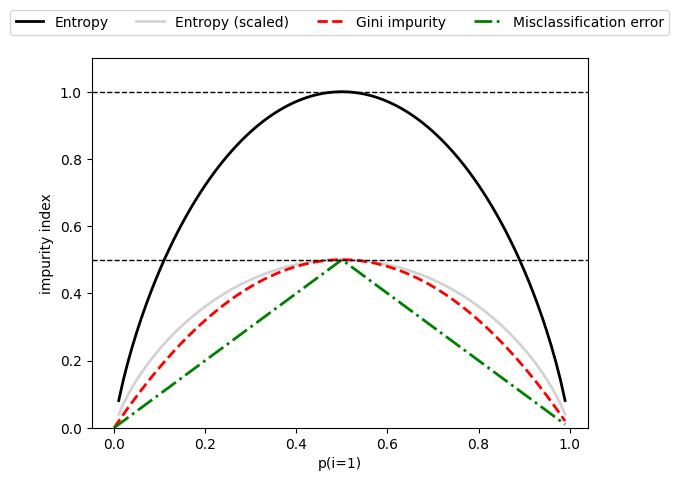

In [ ]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

Now, when the decision tree makes its splits, it does so attempting to minimize whatever metric (classification error rate, Gini impurity, or entropy) you choose. Which one should you choose? The truth is, most of the time it doesn't make a big difference - they all lead to similar trees with similar performance. Gini impurity is slightly faster to compute (no logarithms) so it's a reasonable default.

### The CART Algorithm

Sklearn uses the *Classification and Regression Tree* algorithm to train decision trees. The algorithm works by first splitting the training set into two subsets using a single feature $k$ (in our iris data example, there are two possible features we can use - petal width and petal length). The threshold $t_{k}$ for the split is the one that produces the most pure subsets, weighted by their size:

<center>
  $\displaystyle J(k,t_{k}) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}$
</center>

Here $m$ is the total size of the set before the split, $m_{left}$ is the number of observations on the "left" split, $m_{right}$ is the number of observations on the"right" split, and $G_{left}$ and $G_{right}$ are the Gini impurity of, respectively, the left and right splits.

Once the CART algorithm has split the training set in two, it splits the subsets using the same logic, and continues with this process until a stopping criterion (like maximum depth) is reached.

The CART algorithm is a *greedy* algorithm, which means it always takes the maximal choice on every step. Generally speaking, greedy algorithms produces solutions that are reasonably good, but aren't necessarily the best. However, finding the overall best solution for a decision tree requires an amount of time that grows exponentially with the sample size, which generally speaking isn't fesible.

Once the decision tree has been created, making predictions with it just requires a traversal from the root to a leaf. Most decision trees are approximately balanced, so traversing the tree requires going through roughly $O(\log_{2}(m))$ nodes. Since each node only requires checking the value of one feature, the overall prediction time complexity is independent of the number of features, which means predictions are very fast, even when dealing with large training sets.

### Overfitting and Regularization

If left unconstrained, a decision tree will adapt itself to the training data, fitting it very closely - most likely overfitting it.

To avoid overfitting the training data, you need to restrict the decision tree's freedom during training. This is called *regularization*. Some regularization hyperparameters available for decision trees include:


* *max_depth* - How deep the decision tree is allowed to go.
* *max_features* - The maximum number of features that are evaluated for splitting at each node.
* *max_leaf_notes* - The maximum number of leaves the tree is allowed to have.
* *min_samples_split* - The minimum number of samples a node must have before it can be split.
* *min_samples_leaf* - The minimum number of samples a leaf node must have to be created.
* *min_weight_fraction_leaf* - Same as *min_samples_leaf* but expressed as a fraction of the total number of weighted instances.

Note that other decision tree algorithms work by first training the decision tree without restrictions, and then *pruning* (deleting) unnecessary nodes. This is usually done by estimating whether the probability that the purity improvement is the result of chance, and deleting the children of the node if the probability is above a certain threshold.



### Axis Orientation

Decision trees love orthogonal decision boundaries where all splits are perpendicular to an axis. However, these are not always the best dividing lines.

One way to get around this problem is to scale the data, and then apply a *principal component analysis* transformation, which we'll discuss later. For now just know it rotates the data in a way that reduces the correlation between the  features, which often makes things easier for trees.

We can see this with our iris data. Let's create a small pipeline that scales the data and rotates it using PCA. Then, we'll use a decision tree classifier on this scaled and rotated data.

In [ ]:
pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris);

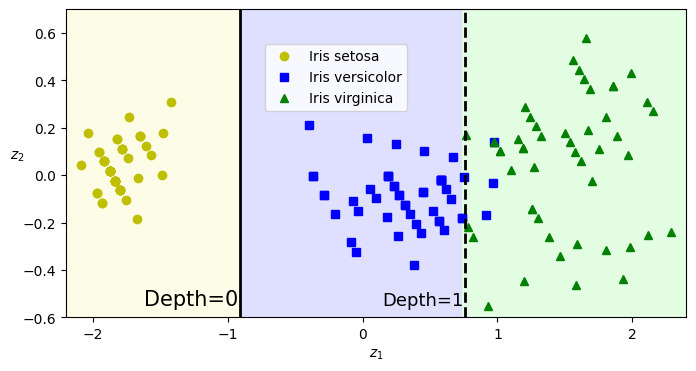

In [ ]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))

plt.show()

A slight improvement on an already quite good classification algorithm.

## Decision Tree Limitations

The main issue with decision trees is they have high variance - small changes to the hyperparameters or the data can result in big changes to the models. As such, unless they task is very simple, decision trees struggle with generalization.

How can we get around this problem? Well, one way could be to create a bunch of decision trees and average their results. This is called using an *ensemble* of trees, and is the basis  for the *random forest* algorithm, a very powerful type of model which we'll discuss next time.

### References


*   [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)
*   [ROC and AUC](https://youtu.be/4jRBRDbJemM?si=TX0UAv7_wiVoxz28)

*   **Song of the Day** [Trees](https://youtu.be/tEiZWUL1SUY?si=UrGBg0jWajn8fxdf), sung by Paul Robeson, with lyrics by [Joyce Kilmer](https://www.poetryfoundation.org/poetrymagazine/poems/12744/trees).